In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import shutil
shutil.copy('/mnt/data/2fec765e-d15b-4ce2-93ba-cc652282907a.png', 'ddpm_paper.png')

Image(filename='ddpm_paper.png')


In [ ]:
!pip install -q -U einops datasets matplotlib tqdm torch

import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

In [ ]:
# ddpm저자는 T=1000번으로 설정
# 베타t 정도는 사용자가 모델링 가능 마치 lr처럼
# 근데 어쨌는 타임 T때는 완전한 노이즈가 되어야
"""
The neural network needs to take in a noised image at a particular time step and return the predicted noise.
Note that the predicted noise is a tensor that has the same size/resolution as the input image.
"""


'\nThe neural network needs to take in a noised image at a particular time step and return the predicted noise.\nNote that the predicted noise is a tensor that has the same size/resolution as the input image.\n'

In [ ]:
def exists(x):
  return x is not None

def default(val ,d):
  if exists(val):
    return val
  return d() if isfunction(d) else d

def num_to_groups(num, divisor):
  groups=num//divisor
  remainder= num%divisor
  arr=[divisor]*groups
  if remainder>0:
    arr.append(remainder)
  return arr

class Residual(nn.Module):
  def __init__(self, fn):
    super().__init__()
    self.fn=fn

  def forward(self, x, *arg, **kwargs):
    return self.fn(x, *arg, **kwargs) + x


def Upsample(dim, dim_out=None):
  return nn.Seuential(
      nn.Upsample(scale_factor=2, mode='nearest'),
      nn.Conv2d(dim, default(dim_out, dim),3,padding=1),
  )

def Downsample(dim, dim_out=None):
  return nn.Sequential(
      Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2),
      nn.Conv2d(dim * 4, default(dim_out, dim), 1),
  )

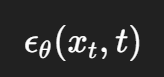

In [ ]:
"""
t값이 달라도 사용하는 입실론세타는 동일 가중치 공유
\epsilon_\theta: 노이즈 예측을 위한 신경망 (ex: U-Net)

\epsilon_\theta(x_t, t)는 "타임스텝 t에서 노이즈 예측"을 위한 함
여기서 \theta는 학습된 파라미터이며, 시간에 따라 바뀌지 않는다
다만, 입력값이 다르기 때문에 출력값은 시간에 따라 다름
"""

class SinusoidalPositionEmbeddings(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.dim=dim # 포지셔널 임베딩의 디멘션

  def forward(self, time): # takes a tensor of shape (batch_size, 1) as input , 다시말해 배치 내 여러 노이즈 이미들의 노이즈 레벨 t 예: [[10], [134], [859], ...]
    device=time.device # 파이토치에서는 서로다른 device(cpu/gpu)에 있는 텐서를 연산에 같이 쓰면 에러남, 그래서 디바이스 통일- 밑 torch.arange에서 사용
    half_dim=self.dim//2
    embeddings=math.log(10000) / (half_dim -1)
    embeddings=torch.exp(torch.arange(half_dim, device=device)*-embeddings)
    embeddings = time[:, None] * embeddings[None, :] # (batch_size, 1)로 변환, embeddings[None, :] # (1, half_dim)로 변환
    embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1) # 트랜스포머처럼 interleave 아니고 그냥 half_dim 끼리 이어붙임
    return embeddings # (batch_size, dim)

# time step t는 단순히 숫자기 문에 그대로 유넷에 넣을수는 없다.
# 그래서 고차원 벡터로 변환해서 네트워크에 주입 예) t_emb = SinusoidalPositionEmbeddings(dim)(t)

In [ ]:
# 유넷의 코어 빌딩 블록
class WeightStandardizedConv2d(nn.Conv2d): # self.weight를 그대로 쓰지 않고, 평균/분산으로 종규화된 weight 계산해서 쓰려고.
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """
    # nn.Conv2d의 __init__이 그대로 상속
    # super().__init__(in_channels=dim, out_channels=dim_out, kernel_size, padding)

    def forward(self, x): # nn.Conv2d에서 forward만 재정
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight # nn.Conv2d내 속성, convolution 필터의 가중치
        # conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)-> print(conv.weight.shape)  # e.g., torch.Size([16, 3, 3, 3])
        # weight.shape == (out_channels필터 개수, in_channels // groups각 필터가 처리할 입력 채널 수, kernel_height, kernel_width) == (o, i, h, w)
        # einops: 텐서 차원관리 해주는 라이브러리, 파이토치 reshape등 가독성 떨어짐
        mean = reduce(weight, "o ... -> o 1 1 1", "mean") # einops의 reduce사용해서 파이토치 텐서 축소. o를 남기고 나머지 차원(i, h, w)은 축소 대상이라는 뜻
        var = reduce(weight, "o ... -> o 1 1 1", partial(torch.var, unbiased=False)) # partial(...)을 써서 einops의 reduce()에 넣을 수 있게 래핑
        normalized_weight = (weight - mean) * (var + eps).rsqrt()

        return F.conv2d( # 커스텀 weight, 직접 제어하고 싶은 경우
            x,
            normalized_weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )
"""
nn.Conv2d — 모듈형 레이어 (자동 weight 관리): 그냥 인, 아웃사이즈, 커널사이즈 등만 넣으면 weight값자체는 알아서 처리
반면 F.conv2d — 함수형 API (weight 수동 입력): weight 입력란이 있음 따라서 커스텀 weight 처리 가능하다
"""

class Block(nn.Module): # 데이터x 받아서 WeightStandardizedConv2d, 기타등등 수행
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding=1) # WeightStandardizedConv2d정의(객체생성). forward는 안한상태
        self.norm = nn.GroupNorm(groups, dim_out) # 정규화(norm), dim_out개의 채널을 groups개의 그룹으로 나눠서 정규
        self.act = nn.SiLU() # 활성화 함수(act), ReLU보다 부드럽고, 음수 입력도 완전히 죽지 않음

    def forward(self, x, scale_shift=None):
        x = self.proj(x) # 데이터에 conv 실행->피처맵 생성
        x = self.norm(x) # 정규화

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x) # 활성화 적용(입력 텐서의 모든 원소에 대해 독립적으로 적용)
        return x # 최종 가공된 피처맵 반환!(WeightStandardized_conv+그룹정규화+activation)


class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        # * 이후에 나오는 인자는 모두 키워드 인자(keyword-only arguments)로만 받을 수 있다는 의미, time_emb_dim=256, groups=4이렇게해서 함수 호출 시 실수 방지, 코드 가독성 향상..
        # 참고) *args는 여러 인자를 튜플로 받음 / **kwargs는 여러개의 키워드 인자를 dict로 받음
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out * 2))
            if exists(time_emb_dim)
            else None
        ) # time_emb_dim값이 있으면 시퀀셜 반환

        self.block1 = Block(dim, dim_out, groups=groups)  # Conv-Norm-Act 블록 정의
        self.block2 = Block(dim_out, dim_out, groups=groups)  # dim_out으로 고정되어 있, feature refinement
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity() # Residual 연결!!!
        # x의 채널수가 f(x) 채널 수와 다른 경우, 채널수 맞추기 위해 1*1 conv로 조정하고 아니면 입력 그대로 통과 (nn.Identity())
        # 통과되면서 입력의 채널 수(dim)를 출력 채널 수(dim_out)에 맞춰줌

    def forward(self, x, time_emb=None):
        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, "b c -> b c 1 1")
            scale_shift = time_emb.chunk(2, dim=1)

        h = self.block1(x, scale_shift=scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x) # Residual 연결!!!
# 입력 feature map x를 두 개의 Conv(+a) 블록 (block1, block2)을 통해 처리하고
# 마지막에 residual 연결(x + f(x))을 통해 결과를 출력

- 어텐션 모듈로, 저자들이 컨볼루션 블록 사이에 추가함
-여기서의 어텐션은 두개의 바리에이션이 있다- 레귤러 멀티헤드, 리니어 어텐션 바이에이션

In [ ]:
class Attention(nn.Module): # 시퀀스 길이에 따라 이차적으로 증가
# Self-Attention을 2D 이미지 feature map에 적용하는 구조: 2D Conv + Rearranging
# Conv만으로는 장거리 의존성(long-range dependency)을 포착하기 어려워서 어텐션 추가
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape # 배치 크기, 채널 수, 높이, 너비
        qkv = self.to_qkv(x).chunk(3, dim=1) # 입력 feature map을 Q, K, V로 나눔
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
            # rearrange는 einops 라이브러리 함수(2D feature map을 멀티헤드 어텐션 입력 포맷으로)
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module): # Linear Attention: 긴 시퀀스에서도 효율적 처리 가능 (선형적 복잡도 증가)
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)


In [ ]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

# Conditional U-Net

the job of the network: is to take in a batch of noisy images and their respective noise levels, and output the noise added to the input.
- the network takes a batch of noisy images of shape (batch_size, num_channels, height, width) and a batch of noise levels of shape (batch_size, 1) as input, and returns a tensor of shape (batch_size, num_channels, height, width)

- 매 스텝 t에 해당하는 노이즈 강도는 고정되어 있지만, 스텝마다 "새롭게 섞이는" 노이즈 양은 매번 다르다

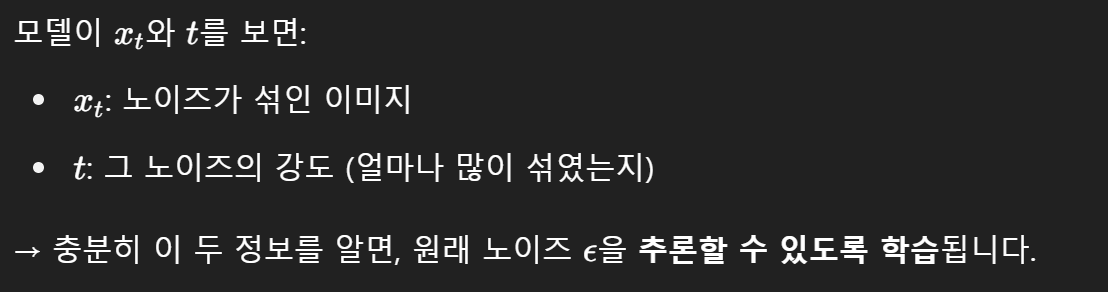

- 1. 노이즈 섞인 배치 이미지마다 컨볼루션 레이어가 적용(초기 feature를 추출)되고, 노이즈 레벨에 따라 포지셔널 임베딩(=타임스텝임베딩)적용된다.
- 2. 여러 다운샘플링 단계가 적용된다. 각 다운샘플링 스테이지는 2개의 레스넷 블록+ 그룹정규화+어텐션+레지듀얼 커넥션+다운샘플 연산
- 3. 네트워크 중간(Bottleneck)에 어텐션과 교차되며 레스넷 블록이 또 적용(ResNet Block → Attention → ResNet Block)
- 4. 다음으로 업샘플링 과정이 시작된다. 각 업샘플링 스테이지는 2개의 레스넷 블록+ 그룹정규화+어텐션+레지듀얼 커넥션+업샘플 연산
- 5. 마지막으로 ResNet 블록과 컨볼루션 레이어를 통해 최종 출력

In [ ]:
# 매 샘플, 매 iteration마다 노이즈는 다름(매번 다른 e가 샘플링)

class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        self_condition=False,
        resnet_block_groups=4,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)

        init_dim = default(init_dim, dim) # init_dim = dim
        self.init_conv = nn.Conv2d(input_channels, init_dim, 1, padding=0) # changed to 1 and 0 from 7, 3
        #  3(RGB니까), dim, 1
        dims = [init_dim, *map(lambda m: dim * m, dim_mults)] # [3, 1*dim, 2*dim, 4*dim, 8*dim]
        in_out = list(zip(dims[:-1], dims[1:])) # [(3,1*dim), ..]

        block_klass = partial(ResnetBlock, groups=resnet_block_groups) # partial:: 기본 인자값이 일부 고정된 함수
        # ResnetBlock을 사용할 때마다, 항상 groups=resnet_block_groups를 기본 인자로 포함


        # time embeddings
        time_dim = dim * 4

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(dim),
            # MLP - 위에서 만든 벡터를 더 expressive하게 변환해서 학습 가능하게 하는 층
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim), # ResnetBlock 생성기
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Downsample(dim_in, dim_out) # 공간 해상도(H×W)를 1/2로 줄이고, 채널 수를 4배 늘렸다가 다시 원하는 수(dim_out)로 줄이는 다운샘플링
                        if not is_last
                        else nn.Conv2d(dim_in, dim_out, 3, padding=1),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        # U-Net의 업샘플링 파트에서는 이전에 저장해둔 downsampling 중간 결과(h)와 현재의 업샘플링 출력을 concat(채널 방향)
                        # 더하는게 아님, 업샘플 feature: [B, 128, H, W] / skip feature: [B, 64, H, W] → concat 후: [B, 192, H, W]
                        # dim_out + dim_in (U-Net의 skip connection은 concat)
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Upsample(dim_out, dim_in)
                        if not is_last
                        else nn.Conv2d(dim_out, dim_in, 3, padding=1),
                    ]
                )
            )

        self.out_dim = default(out_dim, channels)

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim=time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    def forward(self, x, time, x_self_cond=None):
        if self.self_condition:
            x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x_self_cond, x), dim=1)

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time) # 타임 임베딩

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1) # 채널 방향으로 cat
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)


##forward diffusion process
- The forward diffusion process gradually adds noise to an image from the real distribution
- variance schedule
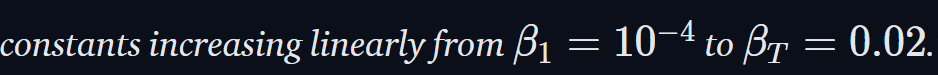

- 그러나 코사인 스케줄 쓰면 결과가 더 좋다는게 밝혀짐

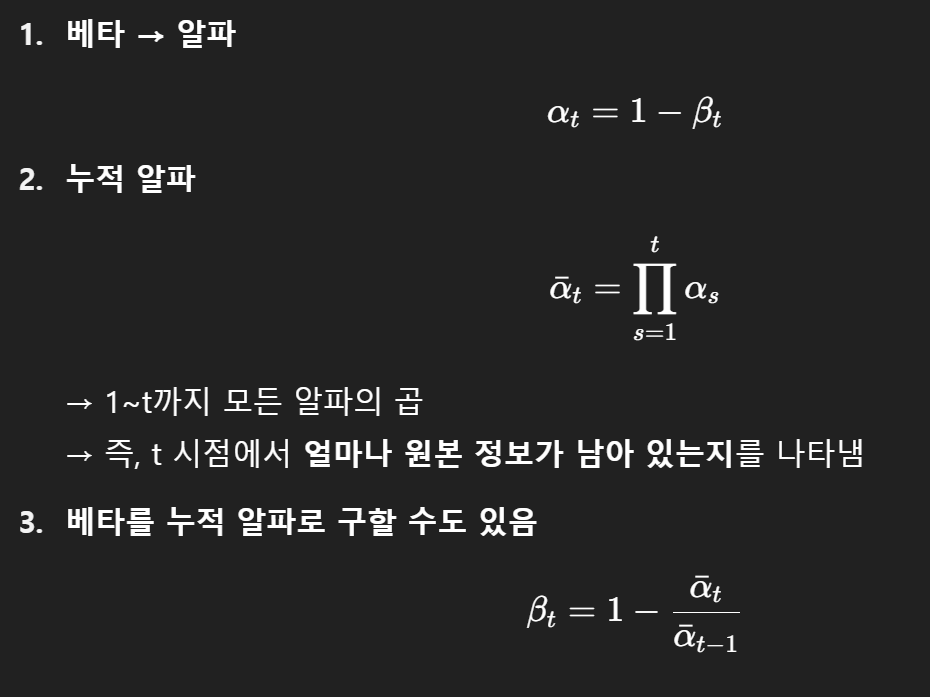

In [ ]:
# 여러 노이즈 스케줄
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1 # T+1
    x = torch.linspace(0, timesteps, steps) # T+1개 점 생성
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2 # 누적 알파값 생성 - 누적알파가 부드럽게 줄어듬
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0] # 처음 값을 기준으로 정규화해서 ᾱ₀ = 1이 되도록
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999) # 너무 작은 β나 너무 큰 β는 학습 안정성에 악영향-> 클리핑

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start


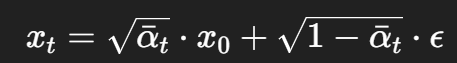

In [1]:

timesteps = 300

# define beta schedule- 타임스텝 커질수록 선형적 증가 버젼
betas = linear_beta_schedule(timesteps=timesteps) # 노이즈의 스케일을 조절, 노이즈 만드는게 아니라 얼마나 섞을지 조절

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)   # 누적 곱
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)  # 왼쪽에 1개 패딩하고 그 값은 1.0
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape): # 각 배치가 속한 t에서 a값을 브로드캐스트(보통3차원) 가능한 상태로 리턴.
    batch_size = t.shape[0] # 배치 크기 저장
    out = a.gather(-1, t.cpu()) # a의 마지막 dim(=0)에서 t의 각 인덱스 선택_ 각 배치가 속한 timestep위치서 필요한 값(1-a)만
    '''
    torch.gather(input, dim, index): input- 원본 텐서, dim- 인덱싱할 축, index- 뽑고 싶은 위치 인덱스들
    결과는 index의 shape을 따라가며, 거기서 지정한 위치의 input 값을 뽑아옵니다.
    a.gather(0, t) # dim=0에서 t의 각 인덱스를 선택

    '''
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device) # sqrt_one_minus_alphas_cumprod[t]의 결과가 (B, 1, 1, 1) shape으로 브로드캐스트가 가능하도록 reshape
    # len(x_shape)는 x_shape 차원 리턴 (x_shape = x.shape)

- 이미지 노이즈 과정

In [ ]:
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw) # PIL image of shape HWC
image

from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

image_size = 128
transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(), # turn into torch Tensor of shape CHW, divide by 255
    Lambda(lambda t: (t * 2) - 1),

])

x_start = transform(image).unsqueeze(0)
x_start.shape

import numpy as np

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

# forward diffusion (using the nice property)
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start) # x_start와 같은 shape, 같은 dtype, 같은 device를 가진 정규분포 따르는 랜덤 값 생성

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape) # 각 배치 타임스텝의 a값 리턴
    sqrt_one_minus_alphas_cumprod_t = extract( # 각 배치 타임스텝의 1-a값 리턴
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise # 타임스텝 t의 노이즈낀 이미지 리턴

def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)
  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze())

  return noisy_image

In [ ]:
# take time step
t = torch.tensor([40])
  # torch.tensor()로 만든 텐서는 기본적으로 학습 불가능- 학습하려면 requires_grad=True로 명시

get_noisy_image(x_start, t)

In [2]:

import matplotlib.pyplot as plt

# use seed for reproducability
torch.manual_seed(0)
# 이미지들을 행렬(grid) 형태로 시각화
def plot(imgs #이미지 리스트
         , with_orig=False,#원본 이미지를 같이 그림?
         row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [3]:
# loss function 모델링
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise) # 타임스텝 t의 노이즈 낀 이미지
    predicted_noise = denoise_model(x_noisy, t) # 유넷같은 백본 통과해서 예측해낸 노이즈 정도

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise) # 두 텐서 간 같은 위치 원소들 차이의 절댓값의 평균/ 배치있어도됨
    elif loss_type == 'l2': # (MSE)
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber": #작은 오차에는 L2처럼 부드럽게, 큰 오차에는 L1처럼 덜 민감하게 델타로 구분해서 구함
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss
'''
a = torch.tensor([1.0, 2.0, 3.0])
b = torch.tensor([1.5, 1.5, 2.5])

F.l1_loss(a, b)
# 결과: mean(|1.0-1.5| + |2.0-1.5| + |3.0-2.5|) = mean(0.5 + 0.5 + 0.5) = 0.5
'''

In [ ]:
from datasets import load_dataset

# load dataset from the hub
dataset = load_dataset("fashion_mnist")
image_size = 28
channels = 1
batch_size = 128


In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader

# define image transformations (e.g. using torchvision)
transform = Compose([
            transforms.RandomHorizontalFlip(), # 50% 확률로 좌우 뒤집기
            transforms.ToTensor(), # PIL Image(0~225) → Tensor [0, 1] 범위 정규
            transforms.Lambda(lambda t: (t * 2) - 1)# [-1, 1] 범위로 정규화
])

# define function
def transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]] # .convert("L") → 흑백(Grayscale) 이미지로 변환 (1채널로)
   del examples["image"]

   return examples

transformed_dataset = dataset.with_transform(transforms).remove_columns("label")

# create dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)


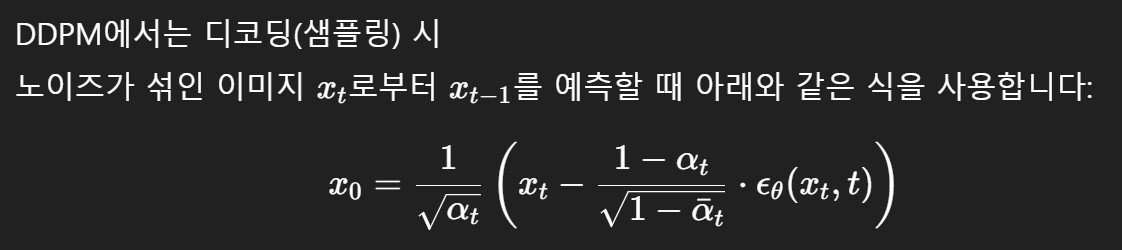

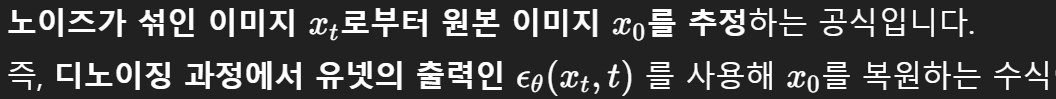

In [ ]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape) # # 각 배치가 속한 t에서 betas값을 브로드캐스트(보통3차원) 가능한 상태로 리턴.
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        # posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))


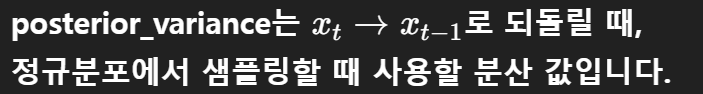

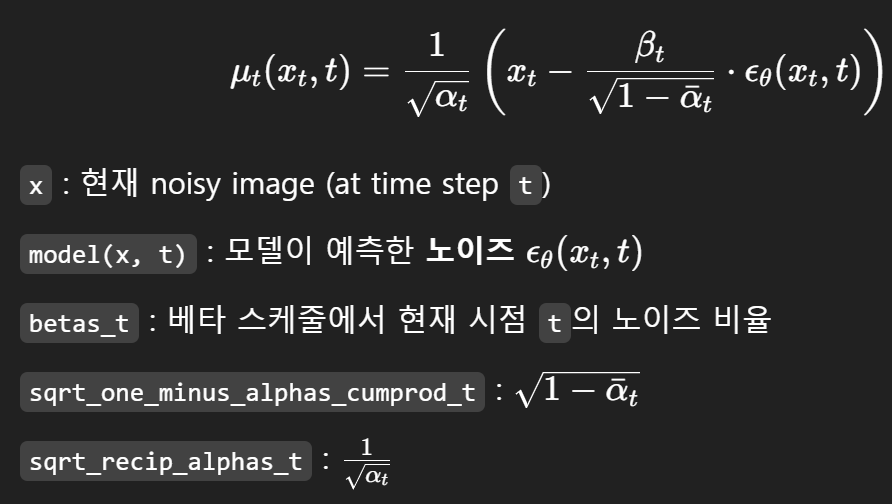

In [ ]:
@torch.no_grad()
def p_sample(model, x, t, t_index): # xt에서 노이즈를 샘플링해서 다음 이미지 xt−1 만드는 과정
# 노이즈 이미지 xt를 받아서 좀 덜 노이즈한 xt-1 리턴
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    # 1-알파햇: 지금까지 누적된 노이즈 양
    if t_index == 0:
        return model_mean # 마지막 스텝이면 deterministic하게 x0=mean 혹은,
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        # 현재 시점이 이전보다 얼마나 더 노이즈한지
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise  # 샘플링한 분포로부터 새로운 노이즈 곱해서 xt-1셍성

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, shape): # t = T ~ 0 까지 p_sample()을 반복 호출(	전체 타임스텝 반복 샘플링 수행)
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device) #완전한 노이즈에서 시작
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs # 복원이지리 리턴

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3): # p_sample_loop를 호출해 샘플 생성
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))


## Train the model

In [ ]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000


In [ ]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)


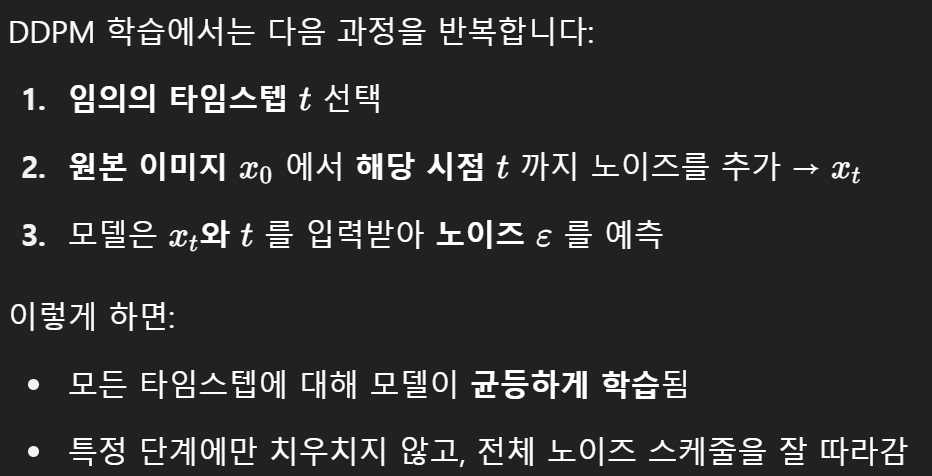

In [ ]:
from torchvision.utils import save_image

epochs = 6

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      # 데이터로더는 데이터 배치 생성기(batch는 딕셔너리 또는 튜플 형태)
      # step은 현재 에포크 내에서 몇 번째 배치인지 의미하는 인덱스이다.
      optimizer.zero_grad()

      batch_size = batch["pixel_values"].shape[0]
      batch = batch["pixel_values"].to(device) # 원본 이미지들

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long() # 각 이미지에 노이즈 적용할 시점 t를 랜덤하게 고름

      loss = p_losses(model, batch, t, loss_type="huber")

      if step % 100 == 0:
        print("Loss:", loss.item())

      loss.backward() # loss기반으로 기울기 계산하고
      optimizer.step() # 기울기 업데이트 (=유넷의 파라미터를 업데이트)

      # save generated images
      if step != 0 and step % save_and_sample_every == 0:
        milestone = step // save_and_sample_every
        batches = num_to_groups(4, batch_size)
        all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
        all_images = torch.cat(all_images_list, dim=0)
        all_images = (all_images + 1) * 0.5
        save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)

Sampling (inference)

- 조건 없는 디퓨전 = Unconditional Diffusion
- 입력: 완전한 가우시안 노이즈
- 출력: 학습된 전체 이미지 분포에서 하나 샘플링

- 즉 학습된 이미지 분포로부터만 그럴듯하게 하나 만듬

In [ ]:
# sample 64 images
samples = sample(model, image_size=image_size, batch_size=64, channels=channels)

# show a random one
random_index = 5
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray")


In [4]:
import matplotlib.animation as animation

random_index = 53

fig = plt.figure()
ims = []
for i in range(timesteps):
    im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save('diffusion.gif')
plt.show()
